# Regresión múltiple con PyMC

In [1]:
# Para usar en Google Colab
# El '%%capture' hace que no se muestren los mensajes. Pueden borrarlo.
# %%capture
# !pip install pymc==5.16.2

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import preliz as pz
import pymc as pm

from pymc.model.fgraph import clone_model

print("ArviZ", az.__version__)
print("PyMC", pm.__version__)
print("PreliZ", pz.__version__)

ArviZ 0.19.0
PyMC 5.16.2
PreliZ 0.9.0


## Contenidos

* [Problema](#problema)
* [Análisis exploratorio de datos](#análisis-exploratorio-de-datos)
* [Modelos](#modelos)
    * [Modelo 1](#modelo-1)
        * [Visualización de la media condicional](#visualización-de-la-media-condicional)
        * [Visualización de la distribución predictiva condicional](#visualización-de-la-distribución-predictiva-condicional)
    * [Modelo 2](#modelo-2)
        * [Cálculo _a posteriori_ _a la_ PyMC](#cálculo-a-posteriori-a-la-pymc)
        * [Visualización de la media condicional](#visualización-de-la-media-condicional)
        * [Visualización de la distribución predictiva condicional](#visualización-de-la-distribución-predictiva-condicional)
    * [Comparación de modelos](#comparación-de-modelos)
* [Respuestas](#respuestas)
* [Ejercicios](#ejercicios)
* [Referencias](#referencias)

# Problema

El conjunto de datos `weather_WU` contiene datos climáticos diarios correspondientes a dos ciudades de Australia: Uluru y Wollongong. Dos de las variables que se encuentran son la temperatura a las 9 de la mañana (`temp9am`) y la tempertarua a las 3 de la tarde (`temp3pm`).

Proponga un modelo que permita describir la asociación entre las temperaturas. A partir de su modelo:

* ¿Cuál es la probabilidad de que la temperatura a la tarde sea mayor a 30 °C cuando a la mañana hicieron 22 °C en Uluru? ¿Y en Wollongong?
* Para cada ciudad, ¿cuál es la probabilidad de que la temperatura a la tarde sea mayor a 30 °C independientemente de la temperatura de la mañana?
* Para cada ciudad, ¿cuál es la probabilidad de que la temperatura de la tarde sea menor que la de la mañana?

# Análisis exploratorio de datos

Al igual que en la _notebook_ anterior, comenzamos por importar los datos. En este caso, la cantidad de columnas con las que se cuenta es mucho mayor. A nosotros nos interesan solamente las siguientes:

* `temp9am`: Temperatura a las 9 de la mañana (°C)
* `temp3pm`: Temperatura a las 3 de la tarde (°C)
* `location`: Nombre de la ciudad. Puede ser `"Uluru"` o `"Wollongong"`.

In [3]:
local = True
if local:
    url_weather = "../datos/weather_WU.csv"
else:
    url_weather = "https://raw.githubusercontent.com/tomicapretto/introduccion_pymc/main/datos/weather_WU.csv"

df_weather = pd.read_csv(url_weather)

In [4]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   location       200 non-null    object 
 1   mintemp        198 non-null    float64
 2   maxtemp        200 non-null    float64
 3   rainfall       197 non-null    float64
 4   windgustdir    198 non-null    object 
 5   windgustspeed  198 non-null    float64
 6   winddir9am     198 non-null    object 
 7   winddir3pm     199 non-null    object 
 8   windspeed9am   200 non-null    int64  
 9   windspeed3pm   199 non-null    float64
 10  humidity9am    200 non-null    int64  
 11  humidity3pm    200 non-null    int64  
 12  pressure9am    200 non-null    float64
 13  pressure3pm    200 non-null    float64
 14  temp9am        200 non-null    float64
 15  temp3pm        200 non-null    float64
 16  raintoday      197 non-null    object 
 17  risk_mm        197 non-null    float64
 18  raintomorr

Algunos datos relevantes del resumen del conjunto de datos:

* Hay 200 filas u observaciones; se tiene información para 200 días.
* Para algunas variables hay datos faltantes (e.g `windgustdir`), pero no hay datos faltantes para las variables que son relevantes para nosotros (`location`, `temp9am` y `temp3pm`).

Abajo podemos ver que tenemos la misma cantidad de días para cada ciudad.

In [5]:
df_weather["location"].value_counts()

location
Uluru         100
Wollongong    100
Name: count, dtype: int64

Dado que nos interesa estudiar la relación entre la temperatura a las 9 de la mañana con la de las 3 de la tarde, podemos comenzar explorando la distribución de ambas temperaturas.

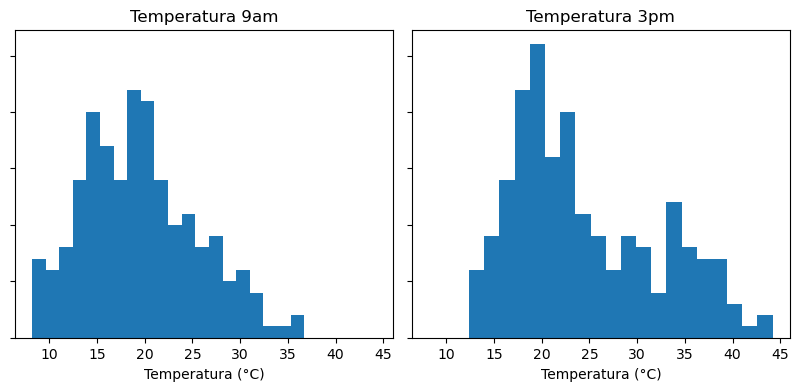

In [6]:
fig, axes = plt.subplots(
    1, 2, figsize=(10, 4), sharex=True, sharey=True, gridspec_kw={"wspace": 0.05}
)

axes[0].hist(df_weather["temp9am"], bins=20)
axes[1].hist(df_weather["temp3pm"], bins=20)

axes[0].set(title="Temperatura 9am", xlabel="Temperatura (°C)", yticklabels=[])
axes[1].set(title="Temperatura 3pm", xlabel="Temperatura (°C)");

Ambas temperaturas presentan un rango variación amplio, aproximadamente entre 9 y 36 grados para la temperatura de la mañana y entre 12 y 45 grados para la temperatura de la tarde. 

No olvidemos que contamos con la ciudad donde se realizaron las mediciones. Veamos como se ven estas distribuciones según la ciudad.

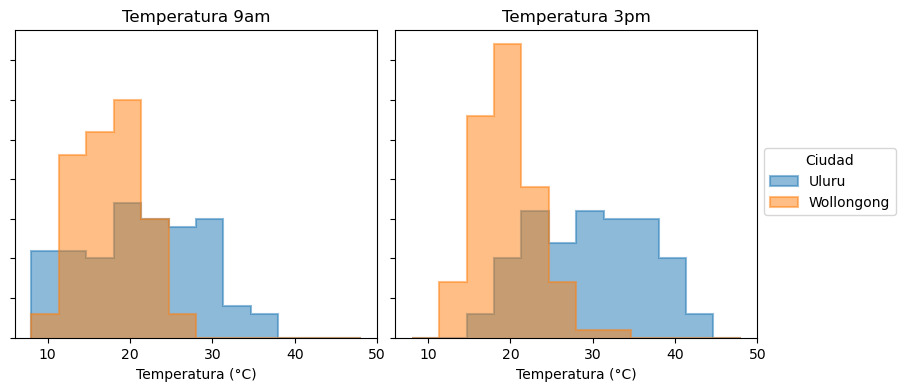

In [7]:
fig, axes = plt.subplots(
    1, 2, figsize=(11, 4), sharex=True, sharey=True, gridspec_kw={"wspace": 0.05, "right": 0.8}
)

bins = np.linspace(8, 48, num=13)

df_u = df_weather.loc[df_weather["location"] == "Uluru"]
df_w = df_weather.loc[df_weather["location"] == "Wollongong"]

axes[0].hist(
    df_u["temp9am"], histtype="step", bins=bins, color="C0", lw=1.5, alpha=0.5, fill=True
)
axes[0].hist(
    df_w["temp9am"], histtype="step", bins=bins, color="C1", lw=1.5, alpha=0.5, fill=True
)

axes[1].hist(
    df_u["temp3pm"], histtype="step", bins=bins, 
    color="C0", lw=1.5, alpha=0.5, fill=True, label="Uluru"
)
axes[1].hist(
    df_w["temp3pm"], histtype="step", bins=bins, 
    color="C1", lw=1.5, alpha=0.5, fill=True, label="Wollongong"
)

axes[1].legend(
    title="Ciudad",
    loc="center left",
    bbox_to_anchor=(0.8, 0.5),
    bbox_transform=fig.transFigure
)

axes[0].set(title="Temperatura 9am", xlabel="Temperatura (°C)", yticklabels=[])
axes[1].set(title="Temperatura 3pm", xlabel="Temperatura (°C)");

Podemos notar dos cosas:

* El rango de variación de las temperaturas es menor para Wollongong que para Uluru.
* Las temperaturas a la tarde suelen ser mayores en Uluru que en Wollongong.

Finalmente, es también conveniente construir un gráfico de dispersión para observar la relación entre las variables.

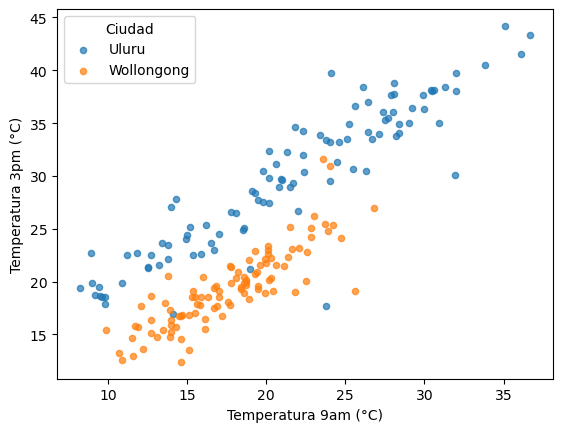

In [8]:
fig, ax = plt.subplots()

for i, (location, df_location) in enumerate(df_weather.groupby("location")):
    ax.scatter(
        df_location["temp9am"], 
        df_location["temp3pm"], 
        color=f"C{i}", 
        s=20, 
        alpha=0.7, 
        label=location
    )

ax.legend(title="Ciudad");
ax.set(xlabel="Temperatura 9am (°C)", ylabel="Temperatura 3pm (°C)");

Como era de esperar, suele suceder que cuando mayor es la temperatura de la mañana, mayor es la temperatura de la tarde. Esto sucede en ambas ciudades y en ambos casos la relación parece ser lineal. Por lo tanto, tiene sentido plantear un modelo de regresión lineal.

Si no se observase una relación entre las variables, o si la relación fuera más compleja que una asociación lineal, no propondríamos un modelo, o consideraríamos un modelo diferente.

# Modelos

En esta sección vamos a construir dos modelos y en ambos vamos a utilizar la siguiente notación para las variables:

* $Y_i$: temperatura a las 3 p.m. de la observación i-ésima.
* $X_i$: temperatura a las 9 a.m. de la observacion i-ésima.

## Modelo 1

El siguiente es un modelo de regresión lineal simple que usa un único intercepto y una única pendiente para ambas ciudades,

$$
\begin{aligned}
Y_i \mid \mu_i, \sigma &\sim \text{Normal}(\mu_i, \sigma^2) \\
\mu_i &= \beta_0 + \beta_1 x_i \\
\end{aligned}
$$

Y así proponemos rápidamente _priors_ para $\beta_0$, $\beta_1$ y $\sigma$.

* $\beta_0$ es la temperatura media a las 3 de la tarde para días donde hacen 0 grados centígrados a las 9 de la mañana. Un _prior_ poco informativo posible está dado por una $\text{Normal}(10, 5^2)$, que concentra casi toda la probabilidad en el intervalo $(-5, 25)$.
* $\beta_1$ es el cambio en la temperatura media a las 3 de la tarde asociado a un incremento de 1 grado centígrado en la temperatura de las 9 de la mañana. Una distribución $\text{Normal}(0, 1^2)$ es sensata ya que concentra la probabilidad en el intervalo $(-3, 3)$.
* $\sigma$ indica la variabilidad en la temperatura a las 3 de la tarde que no está explicada por la temperatura a las 9 de la mañana. Es el desvío estándar de las temeperaturas a la tarde para una temperatura fija de le mañana. Elegimos _prior_ $\text{HalfNormal}(10^2)$ que concentra la probabilidad en el intervalo $(0, 30)$.

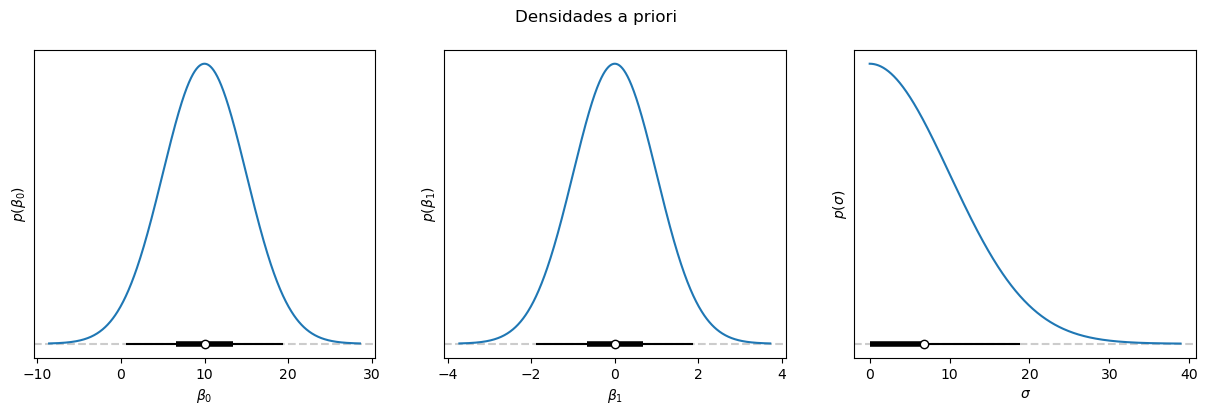

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

pz.Normal(10, 5).plot_pdf(pointinterval=True, legend=False, ax=axes[0])
axes[0].set(xlabel="$\\beta_0$", ylabel="$p(\\beta_0)$");

pz.Normal(0, 1).plot_pdf(pointinterval=True, legend=False, ax=axes[1])
axes[1].set(xlabel="$\\beta_1$", ylabel="$p(\\beta_1)$");

pz.HalfNormal(10).plot_pdf(pointinterval=True, legend=False, ax=axes[2])
axes[2].set(xlabel="$\\sigma$", ylabel="$p(\\sigma)$");

fig.suptitle("Densidades a priori");

Recordemos, no existe tal cosa como **el mejor _prior_**  o el **_prior correcto_** para un modelo en particular. En cambio, hay un rango o conjunto de _priors_ que son razonables y otro que no lo es. La división o frontera entre estos dos conjuntos es difusa, no se puede establecer una regla estricta que deja a _priors_ buenos de un lado y a malos de otro.

El model completo queda:

$$
\begin{aligned}
Y_i \mid \mu_i, \sigma &\sim \text{Normal}(\mu_i, \sigma^2) \\
\mu_i &= \beta_0 + \beta_1 x_i \\
\beta_0 &\sim \text{Normal}(10, 5^2) \\
\beta_1 &\sim \text{Normal}(0, 1^2) \\
\sigma &\sim \text{Normal}^+(10^2) \\
\end{aligned}
$$

Y la implementación en PyMC es la siguiente:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


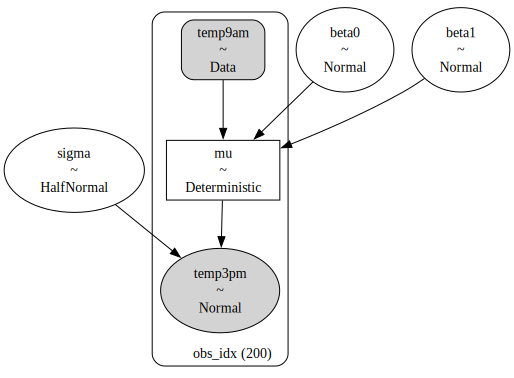

In [10]:
# Coordenadas para las observaciones (de 0 a 199)
coords = {
    "obs_idx": np.arange(len(df_weather))
}

with pm.Model() as model_1:
    # Contenedor de datos para el predictor
    x_data = pm.Data("temp9am", df_weather["temp9am"], dims="obs_idx")

    # Prior para el intercepto
    beta0 = pm.Normal("beta0", mu=10, sigma=5)
    
    # Prior para la pendiente
    beta1 = pm.Normal("beta1", mu=0, sigma=1)

    # Media condicional
    mu = pm.Deterministic("mu", beta0 + beta1 * x_data, dims="obs_idx")

    # Desvío estándar residual
    sigma = pm.HalfNormal("sigma", sigma=10)

    # Verosimilitud, likelihood, modelo observacional
    pm.Normal("temp3pm", mu=mu, sigma=sigma, observed=df_weather["temp3pm"], dims="obs_idx")

    # Obtenemos muestras del posterior
    idata_1 = pm.sample(chains=4, random_seed=1211)

model_1.to_graphviz()

Exploremos el resumen que nos provee ArviZ.

In [11]:
az.summary(idata_1, var_names=["beta0", "beta1", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,4.446,0.974,2.599,6.258,0.026,0.018,1407.0,1389.0,1.0
beta1,1.030,0.048,0.937,1.116,0.001,0.001,1402.0,1488.0,1.0
sigma,4.137,0.212,3.749,4.532,0.005,0.003,1889.0,1605.0,1.0


Primero, las medidas de diagnóstico:

* $\hat{R}$: todos los valores son iguales a 1 (o lo suficientemente cerca) ✅
* Tamaño efectivo de muestra: todos mayores a 1000, más que suficiente para hacer estimaciones mediante técnicas de Monte Carlo ✅
* _Monte Carlo Standard Error_ para la media `mcse_mean` y para el desvío estándar `mcse_sd`: son lo suficientemente pequeños en comparación a las cantidades estimadas ✅

**Nota** acá también podríamos generar un _traceplot_ con `az.plot_trace()`.

Luego, podemos ver qué:

* La temperatura promedio a las 3pm se encuentra entre 2.6 y 6.3 grados centígrados cuando la temperatura a las 9am es de cero grados.
    * No podemos dejar de notar que al hacer esta inferencia estamos extrapolando, ya que nunca observamos días con temperaturas de 0 grados a la mañana.
* Por cada incremento de 1 grado centígrado en la temperatura a las 9 de la mañana se espera que la temperatura promedio a las 3 de la tarde incremente entre 0.93 y 1.11 grados (prácticamente 1 grado).
* Para una temperatura dada a la mañana, la temperatura a la tarde se encuentra a $\pm 8$ grados centígrados de la media. Lo interpretamos de esta forma por estar trabajando con un modelo observacional normal.

### Visualización de la media condicional

Podríamos visualizar, por ejemplo, muestras para la recta de la media $\mu$. Cada una de las muestras del _posterior_ se corresponde con una recta distinta, dadas por $\beta_0$ y $\beta_1$. Debajo seleccionamos al azar 20 rectas (pares de $\beta_0$ y $\beta_1$) con `az.extract()`.

In [12]:
posterior_draws = az.extract(
    idata_1, group="posterior", var_names=["beta0", "beta1"], num_samples=20
)

# Obtenemos un Dataset de xarray con los valores muestreados de `beta0` y `beta1`
posterior_draws

<xarray.Dataset> Size: 800B
Dimensions:  (sample: 20)
Coordinates:
  * sample   (sample) object 160B MultiIndex
  * chain    (sample) int64 160B 2 1 3 2 3 1 3 1 3 1 1 2 0 1 3 3 3 3 1 3
  * draw     (sample) int64 160B 262 622 680 874 336 896 ... 836 132 347 686 790
Data variables:
    beta0    (sample) float64 160B 2.122 4.897 5.121 4.337 ... 4.032 3.857 3.8
    beta1    (sample) float64 160B 1.127 1.018 0.9962 ... 1.037 1.054 1.032
Attributes:
    created_at:                 2024-09-02T13:45:42.800533+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  5.16.2
    sampling_time:              4.282042980194092
    tuning_steps:               1000

Luego graficamos las rectas. Esto nos permite percibir por donde se encuentra la media de la respuesta $Y$ para diferentes valores de $X$.

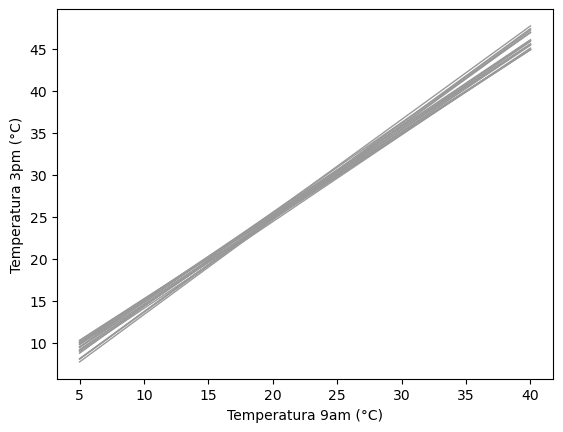

In [13]:
x_grid = np.linspace(5, 40, num=10)

fig, ax = plt.subplots()

for b0, b1 in zip(posterior_draws["beta0"].to_numpy(), posterior_draws["beta1"].to_numpy()):
    ax.plot(x_grid, b0 + b1 * x_grid, color="0.6", lw=1)

ax.set(xlabel="Temperatura 9am (°C)", ylabel="Temperatura 3pm (°C)");

Si utilizamos todas las muestras del _posterior_, podemos graficar el promedio de $\mu_i \mid x_i$ y un intervalo de credibilidad. Debajo lo calculamos "a mano" a partir de las muestras que trabajamos como _arrays_ de NumPy.

In [14]:
# Grilla de valores para la temperatura a las 9am
x_grid = np.linspace(5, 45, num=200)

# Guardamos muestras del intercepto y la pendiente como arrays de NumPy
b0_draws = idata_1["posterior"]["beta0"].to_numpy().flatten()
b1_draws = idata_1["posterior"]["beta1"].to_numpy().flatten()

# A partir del intercepto y la pendiente, obtenemos el posterior de \mu_i | x_i 
mu = b0_draws[:, np.newaxis] + b1_draws[:, np.newaxis] * x_grid[np.newaxis]

# Tenemos un array de (cantidad muestras del posterior,  cantidad valores de 'x' en la grilla)
mu.shape

(4000, 200)

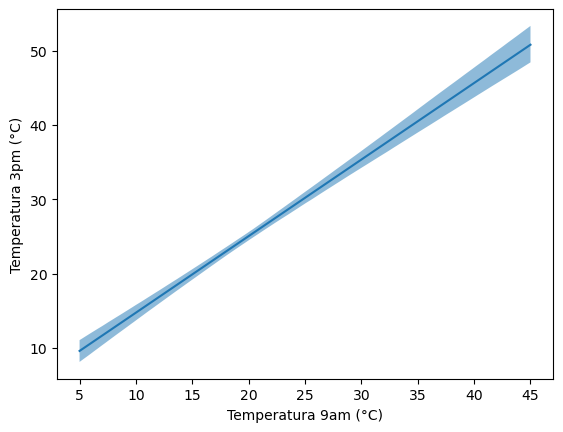

In [15]:
# Calculamos la media y los cuantiles para el gráfico
mu_mean = np.mean(mu, axis=0)
mu_lower, mu_upper = np.quantile(mu, (0.025, 0.975), axis=0)

# Visualizamos la recta que representa la media de mu_i y la banda de credibilidad
fig, ax = plt.subplots()
ax.plot(x_grid, mu_mean)
ax.fill_between(x_grid, mu_lower, mu_upper, alpha=0.5);

ax.set(xlabel="Temperatura 9am (°C)", ylabel="Temperatura 3pm (°C)");

El gráfico anterior representa la inferencia sobre la media condicional de la temperatura a las 3 de la tarde para diferentes valores de temperatura a las 9 de la mañana. Si quisieramos ver la inferencia sobre las temperaturas a las 3pm, no sobre la media, necesitamos trabajar con la distribución predictiva _a posteriori_. Para eso, obtenemos valores del modelo observacional normal a partir de los valores de $\mu$ y $\sigma$ en nuestro _posterior_.

### Visualización de la distribución predictiva condicional

In [16]:
# Para la predictiva necesitamos las muestras de 'sigma'
# Obtenemos un array de longitud 4000 (la cantidad de muestras del posterior)
sigma = idata_1["posterior"]["sigma"].to_numpy().flatten()

# Creamos un generador reproducible de números aleatorios
rng = np.random.default_rng(1234)

# Generamos valores manualmente a traves de NumPy
y_rvs = rng.normal(loc=mu, scale=sigma[:, np.newaxis])
y_rvs

array([[ 3.28803623, 10.8721658 , 14.06722053, ..., 51.06136234,
        46.73814727, 58.73294805],
       [12.29829029,  8.4499092 , 18.67586425, ..., 43.49746788,
        49.3830972 , 49.0820867 ],
       [12.27131834,  9.20612785,  8.00566578, ..., 45.64232784,
        46.2600414 , 48.1210612 ],
       ...,
       [ 4.11277548,  7.49993188,  8.81165424, ..., 45.48758438,
        53.9310677 , 50.49756065],
       [ 5.87937739, 11.82740236, 16.7266223 , ..., 49.48250468,
        52.16783455, 54.4576867 ],
       [10.45241235, 11.48191947, 15.10271118, ..., 50.03867971,
        46.25528609, 50.31279585]])

Para crear la visualización seguimos la misma lógica que para la de la media condicional _a posteriori_.

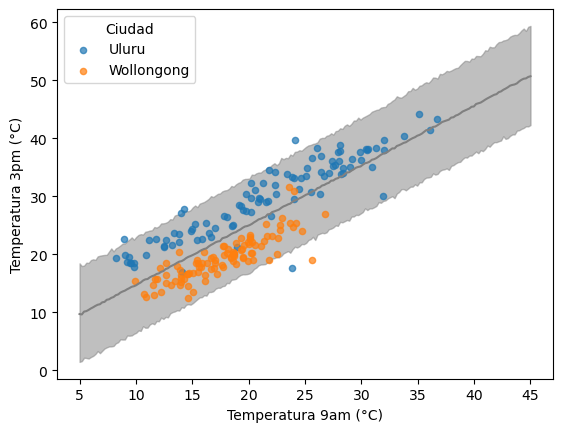

In [17]:
# Calculamos la media y los cuantiles para el gráfico
y_mean = np.mean(y_rvs, axis=0)
y_lower, y_upper = np.quantile(y_rvs, (0.025, 0.975), axis=0)

# Visualizamos la recta que representa la media de y_i y la banda de credibilidad
fig, ax = plt.subplots()
ax.plot(x_grid, y_mean, color="0.5")
ax.fill_between(x_grid, y_lower, y_upper, alpha=0.5, color="0.5")

# Agregamos los valores observados para cada ciudad
for i, (location, df_location) in enumerate(df_weather.groupby("location")):
    ax.scatter(
        df_location["temp9am"], 
        df_location["temp3pm"], 
        color=f"C{i}", 
        s=20, 
        alpha=0.7, 
        label=location
    )

ax.legend(title="Ciudad")
ax.set(xlabel="Temperatura 9am (°C)", ylabel="Temperatura 3pm (°C)");

Por un lado, vemos que la banda que representa las predicciones que realiza nuestro modelo contienen a la mayoría de los valores observados. Por otro, no podemos dejar de notar que los puntos de Uluru quedan en general por encima de la media y los de Wollongong por debajo. Es decir, si bien parece que la asociación entre las temperaturas está bien representada, la recta de regresión y la distribución predictiva condicional no representan a ninguna de las dos ciudades en particular. 

## Modelo 2

Una extensión posible al modelo anterior que incorpora el factor ciudad, es un modelo que utiliza un intercepto distinto para cada ciudad. Este modelo asume que la relación entre las temperaturas es la misma para ambas ciudades, pero que la temperatura "base" reperesentada por el intercepto puede no ser necesariamente la misma. 

Resumimos el modelo de la siguiente manera:

$$
\begin{aligned}
Y_i \mid \mu_i, \sigma &\sim \text{Normal}(\mu_i, \sigma^2) \\
\mu_i &= \beta_{0, j[i]} + \beta_1 x_i \\
\beta_{0, j} &\sim \text{Normal}(10, 5^2) \quad \forall \ j = 1, 2  \\
\beta_1 &\sim \text{Normal}(0, 1^2) \\
\sigma &\sim \text{Normal}^+(0, 10^2) \\
\end{aligned}
$$

donde $j$ indexa a las dos ciudades disponibles, $j = 1, 2$ y $j[i]$ se lee "el valor de $j$ para la $i$-ésima observación.

En este modelo tenemos dos $\beta_0$ distintos, uno para cada ciudad, $\beta_{0, 1}$ y $\beta_{0, 2}$. Nuestra implementación en PyMC requiere un vector índices que indique con cuál de los dos interceptos se corresponde cada observación. Debajo lo obtenemos usando `np.unique()` junto con el argumento `return_inverse=True`. Esta función devuelve por un lado los nombres de las ciudades y por otro los índices que mapean las observaciones a una de las dos ciudades.

In [18]:
ciudad, ciudad_idx = np.unique(df_weather["location"], return_inverse=True)
print(ciudad)
print(ciudad_idx)

['Uluru' 'Wollongong']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


Las primeras 100 observaciones son de la primer ciudad, Uluru, y las últimas 100 son de Wollongong.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


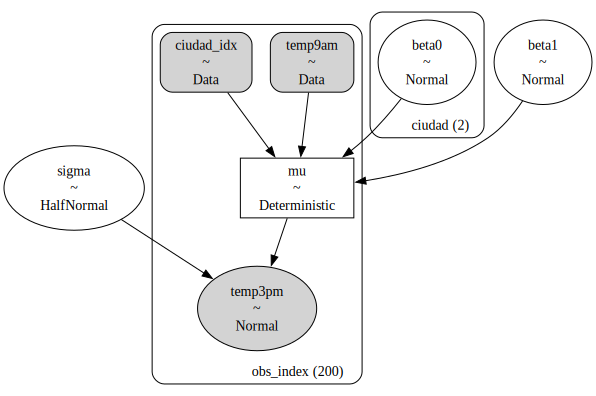

In [19]:
# No solo tenemos coordenadas para las observaciones,
# también tenemos coordenadas para las ciudades (hay 2 ciudades)
coords = {
    "ciudad": ciudad,
    "obs_index": np.arange(len(df_weather))
}

with pm.Model(coords=coords) as model_2:
    # Contenedores de datos para la temperatura a la mañana y 
    # para el índice que determina a que ciudad pertenece cada observación
    x_data = pm.Data("temp9am", df_weather["temp9am"], dims="obs_index")
    ciudad_idx_data = pm.Data("ciudad_idx", ciudad_idx, dims="obs_index")

    # Intercepto
    # 'beta0' es un vector que tiene tantos elementos como ciudades en las coordenadas.
    # Como hay 2 ciudades, tenemos 2 'beta0'.
    beta0 = pm.Normal("beta0", mu=10, sigma=5, dims="ciudad")

    # Pendiente: seguimos utilizando una sola pendiente
    beta1 = pm.Normal("beta1", mu=0, sigma=1)

    # Media condicional
    # Para cada observación seleccionamos el 'beta0' correspondiente
    mu = pm.Deterministic("mu", beta0[ciudad_idx_data] + beta1 * x_data, dims="obs_index")
    
    # Desvío estándar, no cambia
    sigma = pm.HalfNormal("sigma", sigma=10)

     # Verosimilitud, likelihood, modelo observacional
    pm.Normal("temp3pm", mu=mu, sigma=sigma, observed=df_weather["temp3pm"], dims="obs_index")

    idata_2 = pm.sample(chains=4, random_seed=240806)

model_2.to_graphviz()

El resultado de `to_graphviz()` ahora muestra que `"beta0"` tiene longitud 2. Esto es porque hay un `"beta0"` para cada ciudad.

Veamos el _traceplot_.

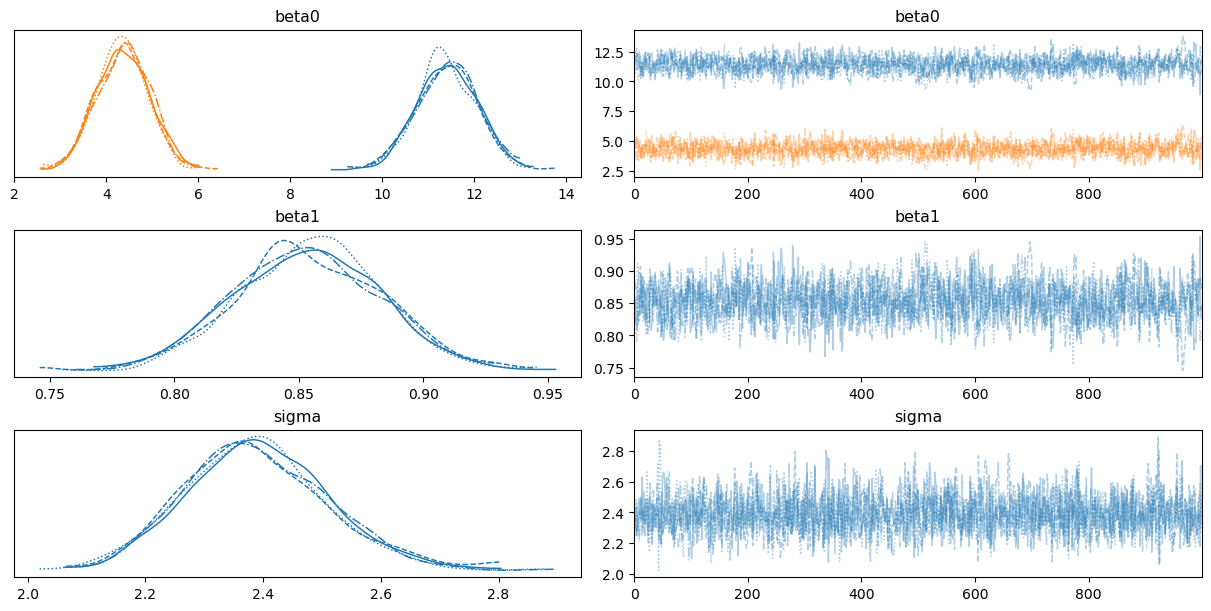

In [20]:
az.plot_trace(idata_2, var_names=["beta0", "beta1", "sigma"], backend_kwargs={"layout": "constrained"});

En los paneles de la derecha vemos que las trazas se ven bien, el comportamiento es estacionario y es imposible distinguir las cadenas. También podemos ver que para `"beta0"` hay dos parámetros, uno para cada ciudad.

Si bien el gráfico permite concluir que el intercepto es mayor para una ciudad que para otra, no nos dice claramente cuál _posterior_ se corresponde con cada ciudad. En estos casos, podemos usar `az.summary()`.

In [21]:
az.summary(idata_2, var_names=["beta0", "beta1", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0[Uluru],11.402,0.657,10.165,12.619,0.018,0.013,1333.0,1747.0,1.0
beta0[Wollongong],4.358,0.563,3.334,5.396,0.015,0.011,1339.0,1594.0,1.0
beta1,0.854,0.029,0.800,0.907,0.001,0.001,1280.0,1620.0,1.0
sigma,2.389,0.121,2.161,2.610,0.003,0.002,2083.0,1812.0,1.0


Podríamos repetir el mismo análisis que hicimos para el primer modelo y llegaríamos a conclusiones similares respecto de los diagnósticos. En cuanto a los _posteriors_ marginales de los parámetros podemos brevemente decir:

* El intercepto, o temperatura base, es mayor para Uluru que para Wollongong.
* La pendiente común está concentrada alrededor de valores levemente menores que en el primer modelo.
* El desvío estándar disminuyó praticamente a la mitad, se concentra entre 2.15 y 2.6. Esto es positivo porque significa que este modelo puede explicar más la variabilidad de la respuesta. En otras palabras, conocer la ciudad además de la temperatura a la mañana resulta en una menor incertidumbre en la inferencia que se hace para la temperatura de la tarde.

Conclusiones similares pueden extraerse visualizando una estimación de las densidades _a posteriori_ mediante `az.plot_dist()`.

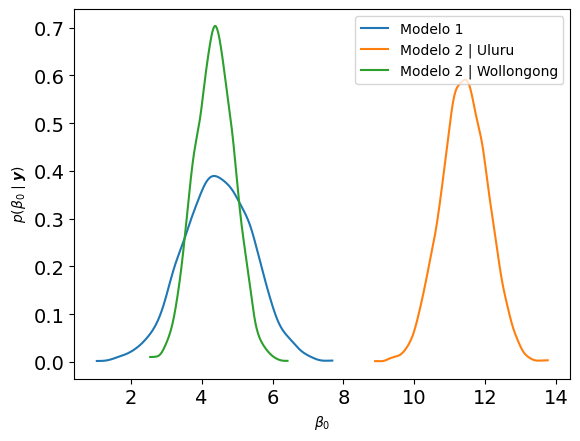

In [22]:
fig, ax = plt.subplots()

az.plot_dist(idata_1.posterior["beta0"], ax=ax, color="C0", label="Modelo 1")
az.plot_dist(idata_2.posterior["beta0"].sel(ciudad="Uluru"), ax=ax, color="C1", label="Modelo 2 | Uluru")
az.plot_dist(idata_2.posterior["beta0"].sel(ciudad="Wollongong"), ax=ax, color="C2", label="Modelo 2 | Wollongong")

ax.set(xlabel="$\\beta_0$", ylabel="$p(\\beta_0 \\mid \\boldsymbol{y})$");

El intercepto de Wollongong en este segundo modelo se parece al que obtuvimos en el primer modelo, pero el de Uluru está concentrado en temperaturas mayores. Con el segundo modelo también se observa menor incertidumbre.

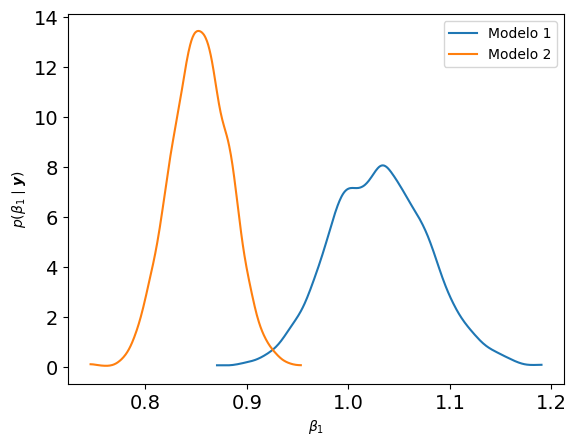

In [23]:
fig, ax = plt.subplots()

az.plot_dist(idata_1.posterior["beta1"], ax=ax, color="C0", label="Modelo 1")
az.plot_dist(idata_2.posterior["beta1"], ax=ax, color="C1", label="Modelo 2")

ax.set(xlabel="$\\beta_1$", ylabel="$p(\\beta_1 \\mid \\boldsymbol{y})$");

La pendiente ahora se concentra en valores levemente menores a los obtenidos en el primer modelo. También se puede notar una menor incertidumbre.

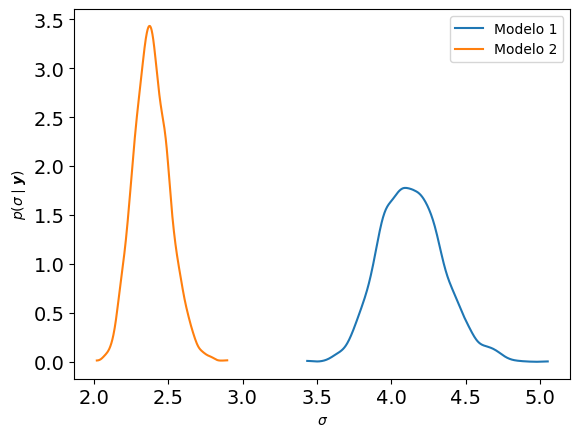

In [24]:
fig, ax = plt.subplots()

az.plot_dist(idata_1.posterior["sigma"], ax=ax, color="C0", label="Modelo 1")
az.plot_dist(idata_2.posterior["sigma"], ax=ax, color="C1", label="Modelo 2")

ax.set(xlabel="$\\sigma$", ylabel="$p(\\sigma \\mid \\boldsymbol{y})$");

La media _a posteriori_ de $\sigma$, que representa cuanto "ruido" hay en el modelo, disminuye practicamente a la mitad entre el primer y segundo modelo.

### Cálculo _a posteriori_ _a la_ PyMC

En base al primer modelo visualizamos la distribución _a posteriori_ de  $\mu_i \mid x_i$ y de $Y_i \mid x_i$. Para eso extrajimos las muestras del _posterior_ dentro del `InferenceData` como _arrays_ de NumPy, calculamos $\mu_i$ para valores de $x_i$ en una grilla con cada muestra del _posterior_ y generamos valores de $Y_i$ en base a los $\mu_i$ y $\sigma$ y el generador de números aleatorios normales de NumPy. Dicha tarea fue relativamente sencilla porque trabajamos con un modelo sencillo.

Sin embargo, es más general y robusto hacer que PyMC se encargue de obtener las cantidades de interés en base al _posterior_ (esto ya lo vimos en la _notebook_ sobre regresión simple). Lo único que tenemos que hacer es fijar nuevos valores para los datos y llamar a `pm.sample_posterior_predictive()`. 

La particularidad de este ejemplo es que tenemos que especificar tanto valores para `"temp9am"` como para el índice que indica la ciudad `"ciudad_idx"`. Debajo, utilizamos una grilla que va desde 5 a 40 para `"temp9am"` en ambas ciudades. 

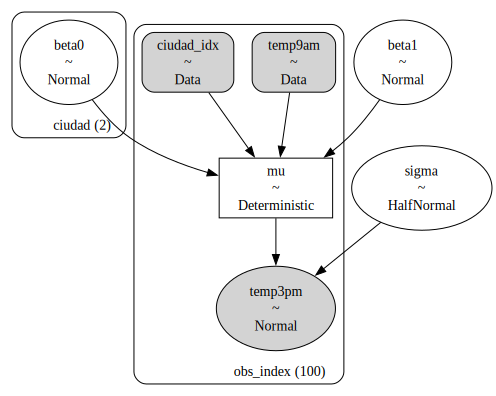

In [25]:
x_grid = np.linspace(5, 40, num=50) # 50 valores

# Clonar el modelo para no alterar el modelo original
with clone_model(model_2) as model_2_cloned:
    pm.set_data(
        new_data={
            "temp9am": np.tile(x_grid, 2), # 100 valores, la grilla 2 veces
            "ciudad_idx": np.repeat([0, 1], 50), # 100 valores, 50 ceros y 50 unos
        },
        coords={"obs_index": np.arange(100)}
    )

model_2_cloned.to_graphviz()

Podemos ver en el grafo que `obs_index` tiene una longitud de 100, a diferencia de la que teníamos en el model original que era de 200. Esto es porque el grafo muestra un modelo que tiene nuevos valores para `"temp9am"`, `"ciudad_idx"` y `"obs_index"`.

Ahora, obtengamos las muestras. Notar que pasamos los siguientes dos argumentos:

* `var_names=["mu", "temp3pm"]` para obtener muestras de tanto `"mu"` como `"temp3pm"`.
* `predictions=True` para que genere un nuevo grupo. Si no lo hacemos se guardará el grupo `posterior_predictive` que requiere que `obs_index` tenga los mismos valores que en `posterior`, cosa que acá no se cumple.

In [26]:
with model_2_cloned:
    # Es importante pasar var_names=]
    predictions = pm.sample_posterior_predictive(
        idata_2, var_names=["mu", "temp3pm"], predictions=True
    )

Sampling: [temp3pm]


Output()

In [27]:
predictions.predictions

<xarray.Dataset> Size: 6MB
Dimensions:    (chain: 4, draw: 1000, obs_index: 100)
Coordinates:
  * chain      (chain) int64 32B 0 1 2 3
  * draw       (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * obs_index  (obs_index) int64 800B 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
Data variables:
    mu         (chain, draw, obs_index) float64 3MB 16.06 16.65 ... 38.04 38.67
    temp3pm    (chain, draw, obs_index) float64 3MB 17.56 13.07 ... 38.32 38.97
Attributes:
    created_at:                 2024-09-02T13:46:02.109144+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  5.16.2

De la longitud de la dimensión `obs_index` se puede inferir que estas muestras se obtuvieron a partir del modelo clonado y no del modelo original.

### Visualización de la media condicional

Para visualizar la media condicional seguimos pasos similares a los que hicimos con el primer modelo. La diferencia acá es que ya tenemos calculados los valores de `"mu"` gracias a PyMC.

Por ejemplo, para mostrar 20 rectas para la media para cada ciudad, volvemos a usar `az.extract()` con `num_samples=20`, pero esta vez indicamos `var_names="mu"`.

In [28]:
mu_draws = az.extract(predictions, "predictions", var_names="mu", num_samples=20)
mu_draws

<xarray.DataArray 'mu' (obs_index: 100, sample: 20)> Size: 16kB
array([[15.13368654, 15.63454208, 15.61350993, ..., 15.17990165,
        15.2124017 , 15.70876928],
       [15.76964626, 16.23825092, 16.21921784, ..., 15.80549463,
        15.84606108, 16.33103182],
       [16.40560597, 16.84195976, 16.82492575, ..., 16.43108761,
        16.47972045, 16.95329437],
       ...,
       [37.91349647, 36.86056766, 37.00225285, ..., 37.27624165,
        37.71653448, 37.73584442],
       [38.54945618, 37.4642765 , 37.60796076, ..., 37.90183463,
        38.35019386, 38.35810696],
       [39.1854159 , 38.06798534, 38.21366867, ..., 38.52742761,
        38.98385324, 38.9803695 ]])
Coordinates:
  * obs_index  (obs_index) int64 800B 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
  * sample     (sample) object 160B MultiIndex
  * chain      (sample) int64 160B 3 0 3 0 0 3 1 0 2 3 0 2 0 1 1 3 3 2 2 2
  * draw       (sample) int64 160B 63 40 269 393 395 859 ... 121 0 436 812 274

Recordemos que `obs_index` tiene una longitud de 100 porque los primeros 50 valores son una grilla, la de Uluru, y los últimos 50 son otra, la de Wollongong.

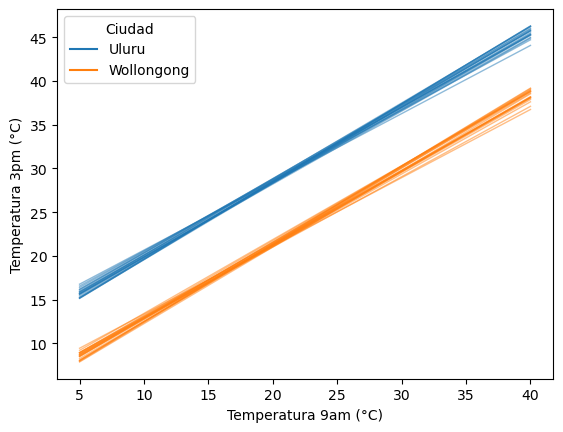

In [29]:
fig, ax = plt.subplots()

for i, mu in enumerate(mu_draws.to_numpy().T):
    # Los primeros 50 valores son para Uluru
    ax.plot(x_grid, mu[:50], color="C0", alpha=0.5, lw=1)
    # Los ultimos 50 valores son para Wollongong
    ax.plot(x_grid, mu[50:], color="C1", alpha=0.5, lw=1)

# Para la leyenda
ax.plot([], [], lw=1.5, color="C0", label="Uluru")
ax.plot([], [], lw=1.5, color="C1", label="Wollongong")
ax.legend(title="Ciudad")

ax.set(xlabel="Temperatura 9am (°C)", ylabel="Temperatura 3pm (°C)");

Podemos observar que, si bien las pendientes son las mismas, la temperatura promedio de la tarde en Uluru es siempre mayor que la de Wollongong, para cualquier temperatura dada en la mañana.

### Visualización de la distribución predictiva condicional

Ahora veamos como estimar una línea media y bandas de credibilidad para la distribución predictiva condicional para cada ciudad. En este caso, tenemos que usar las muestras en la variable `"temp3pm"`.

In [30]:
predictions.predictions["temp3pm"]

<xarray.DataArray 'temp3pm' (chain: 4, draw: 1000, obs_index: 100)> Size: 3MB
array([[[17.55802926, 13.07348261, 19.67704611, ..., 36.08547645,
         32.86583476, 34.33862731],
        [15.84783532, 21.68559881, 20.15464765, ..., 38.84957362,
         38.05263024, 37.86256517],
        [15.58177199, 17.87565879, 20.60713444, ..., 38.07119825,
         36.26442739, 36.2681429 ],
        ...,
        [11.96085957, 15.59515947, 13.8854724 , ..., 37.11866696,
         46.45669201, 37.84696209],
        [15.16835518, 19.13928006, 19.18061339, ..., 39.38768526,
         34.70316375, 36.9521315 ],
        [15.84675929, 18.62453099, 19.92651619, ..., 37.08622335,
         39.40661196, 39.29434651]],

       [[19.28058552, 14.98487743, 15.19831092, ..., 38.00613002,
         34.23393231, 41.30854449],
        [17.31716424, 19.3978843 , 15.06077553, ..., 41.7965228 ,
         35.33105487, 38.40428201],
        [16.21216446, 13.09938836, 15.55104601, ..., 34.70098208,
         39.17359146, 35.36688744],
...
        [17.86271598, 12.80627367, 18.45427061, ..., 39.56156148,
         38.09392574, 38.32587893],
        [12.65750357, 16.28198139, 19.31457489, ..., 36.61396741,
         34.53808643, 37.67373423],
        [14.05189415, 15.84119898, 12.29686597, ..., 38.91984608,
         37.11253642, 41.18004405]],

       [[18.51076482, 17.78172033, 15.7755556 , ..., 41.98443314,
         38.49873445, 39.26144275],
        [17.52468119, 13.03138988, 14.08983369, ..., 41.13946069,
         39.24422083, 34.03163698],
        [18.57109261, 14.34119348, 19.53461465, ..., 34.58590701,
         41.75474805, 40.75758059],
        ...,
        [22.19261546,  9.47868477, 17.7813388 , ..., 45.05219487,
         43.59562548, 41.2012779 ],
        [15.29463929, 15.39337778, 18.84524827, ..., 42.67413038,
         36.15909177, 39.73630885],
        [17.74094543, 16.06682962, 17.87547549, ..., 37.39075526,
         38.32226896, 38.97108966]]])
Coordinates:
  * chain      (chain) int64 32B 0 1 2 3
  * draw       (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * obs_index  (obs_index) int64 800B 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99

Y no usamos el argumento `num_samples` porque queremos usar todas las muestras del _posterior_.

In [31]:
# El `.T` al final transpone el array. Es para que `sample` sea la primera dimensión.
y_draws = az.extract(predictions, "predictions", var_names="temp3pm").T
y_draws

<xarray.DataArray 'temp3pm' (sample: 4000, obs_index: 100)> Size: 3MB
array([[17.55802926, 13.07348261, 19.67704611, ..., 36.08547645,
        32.86583476, 34.33862731],
       [15.84783532, 21.68559881, 20.15464765, ..., 38.84957362,
        38.05263024, 37.86256517],
       [15.58177199, 17.87565879, 20.60713444, ..., 38.07119825,
        36.26442739, 36.2681429 ],
       ...,
       [22.19261546,  9.47868477, 17.7813388 , ..., 45.05219487,
        43.59562548, 41.2012779 ],
       [15.29463929, 15.39337778, 18.84524827, ..., 42.67413038,
        36.15909177, 39.73630885],
       [17.74094543, 16.06682962, 17.87547549, ..., 37.39075526,
        38.32226896, 38.97108966]])
Coordinates:
  * obs_index  (obs_index) int64 800B 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
  * sample     (sample) object 32kB MultiIndex
  * chain      (sample) int64 32kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3
  * draw       (sample) int64 32kB 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999

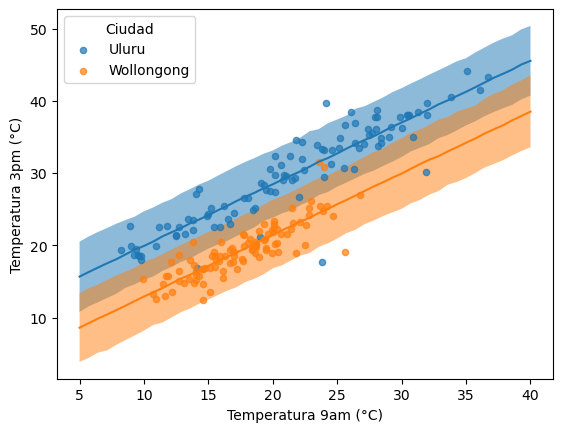

In [32]:
# Calculamos la media y los cuantiles para el gráfico
y_mean = np.mean(y_draws, axis=0)
y_lower, y_upper = np.quantile(y_draws, (0.025, 0.975), axis=0)

fig, ax = plt.subplots()

# Los primeros 50 valores son para Uluru y los últimos 50 para Wollongong
ax.plot(x_grid, y_mean[:50])
ax.plot(x_grid, y_mean[50:])

ax.fill_between(x_grid, y_lower[:50], y_upper[:50], alpha=0.5)
ax.fill_between(x_grid, y_lower[50:], y_upper[50:], alpha=0.5)

for i, (location, df_location) in enumerate(df_weather.groupby("location")):
    ax.scatter(
        df_location["temp9am"], 
        df_location["temp3pm"], 
        color=f"C{i}", 
        s=20, 
        alpha=0.7, 
        label=location
    )

ax.legend(title="Ciudad")
ax.set(xlabel="Temperatura 9am (°C)", ylabel="Temperatura 3pm (°C)");

Podemos notar diferencias entre este gráfico y el que obtuvimos con el modelo 1:

* La amplitud de las bandas es menor. Esto refleja el decrecimiento en $\sigma$.
* Ahora sí las líneas medias representan el medio de la nube de puntos cada ciudad. Para cada ciudad, hay días por encima y días por debajo de la media. Antes, casi todas las observaciones de Uluru estaban encima y casi todas las de Wollongong por debajo.
* Ninguna de las bandas contiene a todos los puntos para una ciudad. Pero esto no es ni un problema ni es lo que pretendemos. Trabajamos con un intervalo de credibilidad del 95%, es de esperar que haya valores por fuera de las bandas.

## Comparación de modelos

Construimos dos modelos. Ambos tienen por objetivo ayudarnos a entender la asociación entre la temperatura de la mañana y la de la tarde, y permitirnos predecir la temperatura de la tarde para una temperatura de la mañana dada. 

La pregunta del millón es, ¿cuál de los dos modelos es mejor?

La respuesta, naturalmente, no es sencilla. Primero, tenemos que establecer que significa ser "mejor" mediante algún criterio de comparación. Segundo, necesitamos una métrica que permita medir o evaluar a cada modelo según ese criterio.

Un posible _score_ predictivo para un determinado valor $y_i$ es la densidad que el modelo le asocia (también llamada densidad predictiva),

$$
\int p\left(y_i\mid\theta\right) p(\theta\mid \boldsymbol{y}) d\theta
$$

A partir de las muestras del _posterior_, podemos estimar la densidad predictiva para una observación de la siguiente manera:

$$
\frac{1}{S}\sum_{s=1}^S p(y_i\mid \theta^{(s)})
$$

donde $S$ indica la cantidad de muestras del _posterior_. La expresión anterior dice que evaluamos la densidad del modelo observacional con cada una de las muestras del _posterior_ y luego promediamos los valores obtenidos.

El _score_ predictivo total (para todas las observaciones) es la _log-posterior pointwise predictive density_ ($\text{lpd}$)

$$
\text{lpd} =  {\sum_{i=1}^{N}} {\log} \left({\int p\left(y_i\mid\theta\right) p(\theta\mid \boldsymbol{y})}d\theta \right)
$$

Esta es simplemente la suma del logaritmo de las densidades predictivas para todas las observaciones y se puede estimar a través de muestras del posterior

$$
\hat{\text{lpd}} = {\sum_{i=1}^{N}} {\log} \left( {\frac{1}{S} \sum_{s=1}^{S} p\left(y_i\mid\theta^{(s)}\right)} \right)
$$

¿Cómo se interpreta este valor? A mayor $\text{lpd}$, mejor es el ajuste del modelo.

La $\text{lpd}$ se basa en las densidades predictivas para cada observación calculadas a partir de un _posterior_ estimado con todas las observaciones. Es decir, la estimación de la densidad predictiva para la observación $i$-ésima se basa en un _posterior_ que incluye el efecto de la observación $i$-ésima.

En cambio, es deseable estimar una cantidad que mida la capacidad predictiva del modelo en un conjunto de datos no utilizado para obtener el _posterior_ (i.e., conjunto de datos de evaluación). Por ejemplo, el valor esperado de $\text{lpd}$ en un nuevo conjunto de datos, el $\text{elpd}$. Pero no contamos con tal conjunto de datos, ¿y entonces? Una solución consiste en utilizar la técnica de validación cruzada que estima la capacidad predictiva de un modelo en un nuevo conjunto de datos, reutilizando el conjunto de datos original. 

En el caso de utilizar _Leave One Out Cross Validation_ (LOO-CV) tendríamos:

$$
\hat{\text{elpd}}_{LOO} = \sum_{i=1}^{N} \log \left( \frac{1}{S} \sum_{s=1}^{S} p\left(y_i\mid\theta_{-i}^{(s)}\right) \right)
$$

donde los $\theta^{(s)}_{−i}$ son muestras del posterior de $\theta$ obtenido sin considerar la $i$-ésima observación.

El problema de hacer LOO-CV es que, si tenemos $n$ observaciones, es necesario ajustar el modelo $n$ veces. Y ajustar un modelo bayesiano $n$ veces no suele ser factible en la práctica. Por ese motivo, existen técnicas que aproximan el resultado que se hubiera tenido si se realizara LOO-CV para estimar el $\text{elpd}$. Una de las propuestas usa la "importancia" de cada observación en el _posterior_ y da lugar a una técnica que se conoce como _Pareto-smoothed importance sampling cross-validation_ (PSIS-LOO CV). Con esta técnica, se obtiene una estimación del $\text{elpd}$ que se hubiera obtenido mediante LOO-CV, pero solo es necesario ajustar el modelo una única vez con todo el conjunto de datos.

Vamos a estimar esta métrica de desempeño utilizando una función de ArviZ. Esta función requiere que nuestro `InferenceData` tenga un grupo llamado `log_likelihood` que contiene el logaritmo de la densidad predictiva para cada observación y muestra del _posterior_. Por defecto, PyMC no calcula esta cantidad pero se puede calcular facilmente con `pm.compute_log_likelihood()`.

In [33]:
with model_1:
    idata_1.extend(pm.compute_log_likelihood(idata_1))

idata_1.log_likelihood

Output()

<xarray.Dataset> Size: 6MB
Dimensions:  (chain: 4, draw: 1000, obs_idx: 200)
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * obs_idx  (obs_idx) int64 2kB 0 1 2 3 4 5 6 7 ... 193 194 195 196 197 198 199
Data variables:
    temp3pm  (chain, draw, obs_idx) float64 6MB -2.746 -3.146 ... -2.346 -2.825
Attributes:
    created_at:                 2024-09-02T13:46:04.259536+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  5.16.2

Ahora hacemos lo mismo para el segundo modelo.

In [34]:
with model_2:
    idata_2.extend(pm.compute_log_likelihood(idata_2))

Output()

Finalmente, para comparar nuestros modelos, pasamos un diccionario con los `InferenceData` a la función `az.compare()`.

In [35]:
df_compare = az.compare({"Modelo 1": idata_1, "Modelo 2": idata_2})
df_compare

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Modelo 2,0,-460.878535,7.263561,0.000000,0.999508,22.635315,0.000000,False,log
Modelo 1,1,-568.473713,2.544565,107.595178,0.000492,8.459005,18.875265,False,log


La función nos devolvió una tabla con una fila por modelo y varias columnas con información. `elpd_loo` es la estimación de $\text{elpd}$ mediante el método PSIS-LOO CV, para la cual también error estándar `se` que sirve para tener una idea de la incertidumbre. La función `az.compare()` no solo estima el $\text{elpd}$ sino que ademas compara y ordena a los modelos. A mayor valor de $\text{elpd}$, mejor la capacidad predictiva del modelo.

La comparación de modelos se hace a partir de la diferencia entre los `elpd_loo` que se encuentra en la columna `elpd_diff`. Vemos que la diferencia entre el modelo 1 y el modelo 2 es de 107.23. ¿Cómo sabemos si esta diferencia es significativa? Un enfoque consiste en construir un intervalo de aproximadamente 95% de confianza restando y sumando a la estimación puntual 2 errores estándar (`dse`). 

El intervalo construido resulta $(107.23 - 2 \cdot 19.14, 107.23 + 2 \cdot 19.14) = (68.95, 145.51)$. Como el mismo no contiene al 0, ni está cerca de hacerlo, se puede concluir que la diferencia entre los $\text{elpd}$ de los modelos 1 y 2 es significativa y por lo tanto el modelo 2 tiene mayor capacidad predictiva.

Esta información también se puede resumir en un gráfico que ArviZ construye con `az.plot_compare()`.

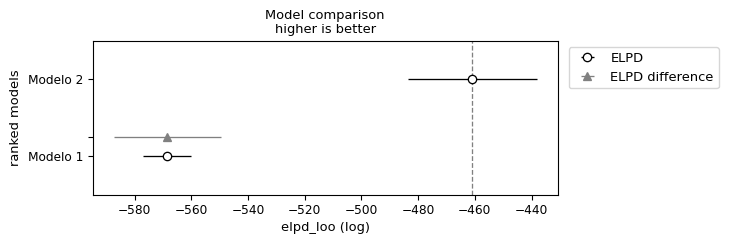

In [36]:
az.plot_compare(df_compare);

Los puntos blancos y las líneas negras representan la estimación del $\text{elpd}$ para cada modelo y su intervalo construido a partir del error estándar en `se`. El triángulo gris y la línea gris representa el intervalo para la diferencia que analizamos arriba. Si este intervalo contuviese a la línea vertical discontinua, no podríamos concluir que un modelo es mejor que el otro.

**Nota**: si quisieramos haber calculado solamente el $\text{elpd}$ para un modelo determinado, sin realizar la comparación, podríamos haber usado la función `az.loo()`.

# Respuestas

Finalmente, pasemos a responder las preguntas planteadas originalmente.

> ¿Cuál es la probabilidad de que la temperatura a la tarde sea mayor a 30 °C cuando a la mañana hicieron 22 °C en Uluru? ¿Y en Wollongong?

Obtengamos muestras de la predictiva _a posteriori_ para ambas ciudades cuando `"temp9am"` es 22 grados. Podríamos hacerlo a mano o bien utilizando `pm.sample_posterior_predictive()` de PyMC.

In [37]:
with clone_model(model_2):
    pm.set_data(
        new_data={"temp9am": [22, 22], "ciudad_idx": [0, 1]},
        coords={"obs_index": [0, 1]}
    )
    preds = pm.sample_posterior_predictive(idata_2, predictions=True)

Sampling: [temp3pm]


Output()

Ahora calculamos la proporción de muestras de la distribución predictiva que es mayor a 30, para cada ciudad. 

Para Uluru, la probabilidad está alrededor de 0.53.

In [38]:
(preds.predictions.sel(obs_index=0)["temp3pm"] > 30).mean().item()

0.53175

En la celda anterior se realizan varios pasos en una sola línea. Aunque esta concisión puede ser atractiva si ya sabemos qué es lo que está haciendo el código, puede resultar confuso si es de las primeras veces que lo leemos. Debajo mostramos el mismo proceso, pero separando cada paso en líneas de código distintas

In [39]:
# Seleccionar las muestras de la distribución predictiva para la primera observación, Uluru
resultado = preds.predictions.sel(obs_index=0)

# Seleccionar la variable 'temp3pm'
resultado = resultado["temp3pm"]

# Determinar, para cada muestra, si es mayor a 30
resultado = resultado > 30

# Calcular la proporción de muestras mayores a 30
resultado = resultado.mean()

resultado.item()

0.53175

Para Wollongong, la probabilidad es prácticamente 0.

In [40]:
(preds.predictions.sel(obs_index=1)["temp3pm"] > 30).mean().item()

0.00175

También es posible hacer ambas estimaciones a la vez. No se selecciona ningún `obs_index` en particular (i.e. se seleccionan todos) y a la hora de calcular la media se especifica que se hace a través de las dimensiones `"chain"` y `"draw"`, pero no a través de `obs_index`.

In [41]:
(preds.predictions["temp3pm"] > 30).mean(("chain", "draw"))

<xarray.DataArray 'temp3pm' (obs_index: 2)> Size: 16B
array([0.53175, 0.00175])
Coordinates:
  * obs_index  (obs_index) int64 16B 0 1

También podríamos obtener un gráfico donde se muestran ambas distribuciones a la vez.

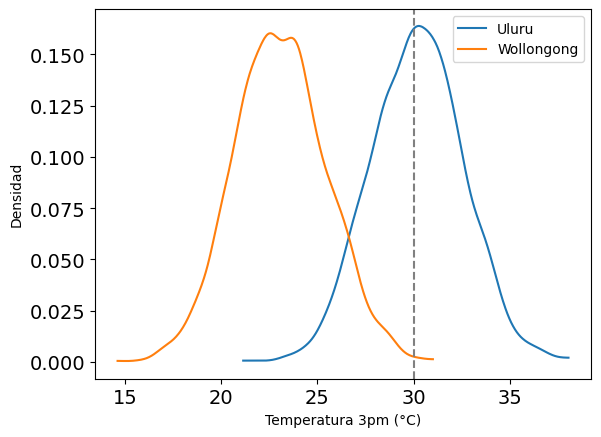

In [42]:
ax = az.plot_dist(preds.predictions.sel(obs_index=0)["temp3pm"], label="Uluru")
az.plot_dist(preds.predictions.sel(obs_index=1)["temp3pm"], ax=ax, color="C1", label="Wollongong")
ax.axvline(30, ls="--", color="0.5")
ax.set(xlabel="Temperatura 3pm (°C)", ylabel="Densidad");

> Para cada ciudad, ¿cuál es la probabilidad de que la temperatura a la tarde sea mayor a 30 °C independientemente de la temperatura de la mañana?

Primero, notemos que, a diferencia de la pregunta anterior, ahora no se nos da una temperatura específica para la mañana. En su lugar, debemos marginalizar sobre todas las posibles temperaturas de la mañana. Una opción sería construir una grilla equiespaciada para las temperaturas de la mañana y obtener muestras predictivas. Sin embargo, esto implicaría asumir que todas las temperaturas son igualmente probables, lo cual no es cierto.

En cambio, obtenemos muestras de la distribución predictiva utilizando los valores observados para la temperatura a las 9 de la mañana y calculamos la probabilidad de interés a partir de ellas.

In [43]:
# Notar que usamos el modelo original porque no necesitamos fijar datos nuevos
with model_2:
    idata_2.extend(pm.sample_posterior_predictive(idata_2))

Sampling: [temp3pm]


Output()

In [44]:
idata_2.posterior_predictive

<xarray.Dataset> Size: 6MB
Dimensions:    (chain: 4, draw: 1000, obs_index: 200)
Coordinates:
  * chain      (chain) int64 32B 0 1 2 3
  * draw       (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * obs_index  (obs_index) int64 2kB 0 1 2 3 4 5 6 ... 194 195 196 197 198 199
Data variables:
    temp3pm    (chain, draw, obs_index) float64 6MB 32.62 28.95 ... 20.4 20.97
Attributes:
    created_at:                 2024-09-02T13:46:09.352215+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  5.16.2

Seleccionamos las muestras para la primer ciudad, Uluru, y calculamos la proporción de ellas que son mayores a 30 a través de todos las muestras y todos los días.

In [45]:
(idata_2.posterior_predictive.sel(obs_index=ciudad_idx==0)["temp3pm"] > 30).mean().item()

0.496475

y luego hacemos lo mismo para Wollongong.

In [46]:
(idata_2.posterior_predictive.sel(obs_index=ciudad_idx==1)["temp3pm"] > 30).mean().item()

0.0033825

En resumen, es bastante probable que se observen temperaturas mayores a 30 grados centígrados en Uluru, pero no así en Wollongong.

> Para cada ciudad, ¿cuál es la probabilidad de que la temperatura de la tarde sea menor que la de la mañana?

Esta pregunta tiene similitudes con la anterior en cuanto a que no se establece una temperatura fija de la mañana. La diferencia es que en vez de comparar la temperatura predicha de la tarde con un valor fijo para cada día, se compara con la temperatura de la mañana de ese día.

No necesitamos volver a obtener muestras de la distribución predictiva porque ya lo hicimos.

In [47]:
# Muestras predictivas de Uluru
y_predictive_uluru = idata_2.posterior_predictive.sel(obs_index=ciudad_idx == 0)["temp3pm"]
y_predictive_uluru

<xarray.DataArray 'temp3pm' (chain: 4, draw: 1000, obs_index: 100)> Size: 3MB
array([[[32.61936385, 28.94926609, 36.45268443, ..., 19.80005123,
         29.78337795, 37.83626607],
        [31.29343414, 32.6861489 , 29.80319219, ..., 27.77712504,
         29.65636428, 36.97278973],
        [30.98914875, 34.21655673, 31.81547718, ..., 20.72029018,
         23.24279712, 36.89684743],
        ...,
        [25.39405413, 28.71434382, 32.74317223, ..., 25.98341474,
         25.32415744, 30.59705396],
        [29.77812566, 30.35520066, 27.79969949, ..., 22.19712191,
         28.15039302, 35.16981664],
        [33.35967386, 33.82785718, 32.3222677 , ..., 22.11949843,
         26.95006314, 36.29388504]],

       [[28.29347476, 30.93075463, 35.07890988, ..., 19.76574672,
         30.94742782, 38.31655537],
        [31.11958471, 27.9042542 , 32.78091695, ..., 21.59899027,
         26.6637269 , 34.89694144],
        [29.63580811, 31.64973721, 33.09328492, ..., 26.00995471,
         26.18956207, 32.48261096],
...
        [28.07616466, 26.35589076, 30.79894033, ..., 23.12854832,
         26.52302705, 37.09897976],
        [31.51751651, 30.51756246, 30.50231999, ..., 21.93513198,
         26.33694029, 35.36715545],
        [31.91635746, 31.80552995, 35.13105963, ..., 24.35016824,
         30.17338471, 33.33733239]],

       [[29.32575776, 34.31129207, 30.608919  , ..., 25.60578271,
         24.07391043, 31.98017032],
        [25.75142449, 29.01304852, 32.52376359, ..., 22.77181971,
         27.86514742, 34.61255525],
        [27.6046605 , 31.77561962, 31.82510862, ..., 26.74744343,
         26.20444608, 34.92475824],
        ...,
        [26.25556666, 28.94618379, 32.34235825, ..., 23.45859829,
         27.98851099, 34.3157385 ],
        [29.07090905, 31.87157056, 31.66937798, ..., 26.1669555 ,
         29.36932209, 32.59498048],
        [32.19785093, 30.97247431, 31.93647237, ..., 23.2015109 ,
         26.70921718, 34.86370566]]])
Coordinates:
  * chain      (chain) int64 32B 0 1 2 3
  * draw       (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * obs_index  (obs_index) int64 800B 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99

¿De dónde sacamos los valores de la mañana para Uluru? Podríamos ir al `DataFrame` de pandas y obtener los valores de allí. Pero como usamos _data containers_ a la hora de implementar nuestro modelo PyMC, estos también están disponibles en el grupo `constant_data` de nuestro `InferenceData`. Vemos que tenemos las dos variables que registramos, `"ciudad_idx"` y `"temp9am"`.

In [48]:
idata_2.constant_data

<xarray.Dataset> Size: 4kB
Dimensions:     (obs_index: 200)
Coordinates:
  * obs_index   (obs_index) int64 2kB 0 1 2 3 4 5 6 ... 194 195 196 197 198 199
Data variables:
    ciudad_idx  (obs_index) int32 800B 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1
    temp9am     (obs_index) float64 2kB 20.9 23.4 24.1 26.4 ... 14.0 23.0 18.4
Attributes:
    created_at:                 2024-09-02T13:45:55.731203+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  5.16.2

Seleccionemos, entonces, la temperatura a las 9 de la mañana para Uluru.

In [49]:
x_observed_uluru = idata_2.constant_data.sel(obs_index=ciudad_idx==0)["temp9am"]
x_observed_uluru

<xarray.DataArray 'temp9am' (obs_index: 100)> Size: 800B
array([20.9, 23.4, 24.1, 26.4, 36.7, 25.1, 14.9, 15.9, 24.6, 15. , 24. ,
       27.4, 18.5, 21.7, 19.8, 28.4, 32. ,  8.9, 22. , 30.9, 27.7, 33.8,
       12.7, 25.5, 16.7, 11.8,  9.5, 21.8, 20.2,  9.6, 17. ,  9. , 26.7,
       29.2, 17.8, 13.4, 30. , 26.1, 19.1, 28.4, 14.3, 21. , 31.3, 19.5,
       12.5, 26.3, 24.5, 27.1, 29. , 16.2, 28.1, 20.6, 22.3, 29.9, 20.8,
       21.5, 30.6, 30.4, 14.1, 10.9, 28. , 15.4, 25.6, 22.3, 23.8,  9.2,
       27.9, 15.2, 18.1, 22.4, 25.2, 27.5, 35.1, 28.1, 20.2, 18.6, 14. ,
       28.2, 21.3, 12.5,  9.8, 23.8, 30.5, 11.2, 13.8, 19.8, 32. ,  8.2,
       36.1, 24. , 20.2,  9.8, 19. , 13.2, 16.5, 31.9,  9.4, 13.8, 19.3,
       26.4])
Coordinates:
  * obs_index  (obs_index) int64 800B 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99

Ahora simplemente calculamos la proporción de muestras donde la temperatura de la tarde es menor a la temperatura de la mañana.

In [50]:
(y_predictive_uluru < x_observed_uluru).mean().item()

0.0009025

En Uluru, es prácticamente imposible que esto suceda.

Hacemos lo mismo para Wollongong y vemos que si bien no es altamente probable que la temperatura de la mañana sea mayor que la de la tarde, sí es un evento que podría suceder (~ 23% de probabilidad).

In [51]:
y_predictive_wollongong = idata_2.posterior_predictive.sel(obs_index=ciudad_idx == 1)["temp3pm"]
x_observed_wollongong = idata_2.constant_data.sel(obs_index=ciudad_idx == 1)["temp9am"]

(y_predictive_wollongong < x_observed_wollongong).mean().item()

0.2352625

# Ejercicios

### Ejercicio 1

Utilizando el Modelo 2, responda la primer pregunta sin usar `pm.set_data()`, manipulando directamente las muestras del _posterior_.

### Ejercicio 2

Implemente un nuevo modelo que extienda al Modelo 2 para que además de utilizar interceptos variables, uno para cada ciudad, se utilicen pendientes variables. Compare los _posteriors_ marginales de las pendientes con los del Modelo 2. Determine si este nuevo modelo tiene una mayor capacidad predictiva que el Modelo 2. ¿Es consistente su conclusión con lo observado en la exploración de datos?

### Ejercicio 3

Considere del conjunto de datos sobre zorros urbanos (`foxes`). El objetivo es predecir la masa del zorro `weight` a partir de otras covariables. Ajuste tres modelos:

* $m_1$: el peso es función del área (`area`);
* $m_2$: el peso es función del tamaño del grupo (`groupsize`);
* $m_3$: el peso es función de área y tamaño de grupo.

Para los modelos $m_1$ y $m_2$, represente gráficamente los resultados, incluyendo la recta de regresión media, su intervalo del 89% y el intervalo de predicción del 89%. ¿Es alguna de las dos variables importantes para predecir la masa de un zorro?

Para el modelo $m_3$, representar gráficamente las predicciones para cada predictor, dejando el otro constante en su valor medio. ¿Qué puede decirse sobre la importancia de las variables para predecir la masa de un zorro?

### Ejercicio 4

El _dataset_ `child_iq` contiene información de los resultados de tests de coeficiente intelectual de niños de 3 años, educación de la madre, y edad de la madre cuando dio a luz.

* Ajuste un modelo de regresión del puntaje del bebé a los 3 años en función de la edad de la madre.
* Ajuste ahora un modelo que incluya la educación de la madre.
* Construya gráficas para mostrar los parámetros obtenidos.
* Realice pruebas predictivas _a posteriori_ para comparar los modelos.
* Compare los ELPD de cada modelo utilizando LOO.

# Referencias

* El gráfico para comparación de modelos sale de [Statistical Rethinking](https://xcelab.net/rm/).
* [Practical Bayesian model evaluation using leave-one-out cross-validation and WAIC](https://arxiv.org/abs/1507.04544)
* [Pareto Smoothed Importance Sampling](https://arxiv.org/abs/1507.02646)
* [Weather Data for 2 Australian Cities](https://bayes-rules.github.io/bayesrules/docs/reference/weather_WU.html)